# Importing the libraries

In [35]:
# Essentials
import numpy as np
import pandas as pd

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Misc
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc 
import missingno as msno

# Warning
import warnings
warnings.filterwarnings('ignore')

In [36]:
# To make this notebook's output stable across runs
np.random.seed(42)

# Exploratory Data Analysis 

Load the data:

In [37]:
train_data = pd.read_csv("datasets/titanic/train.csv")
test_data = pd.read_csv("datasets/titanic/test.csv")

Let's take a peek at the top few rows of the training set:

In [38]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic? // Titanik'te yolcunun kaç kardeşi ve eşi var?
* **Parch**: how many children & parents of the passenger aboard the Titanic? // Titanik'te yolcunun kaç çocuğu ve ebeveyni var?
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

Let's see how many columns and rows we have:

In [39]:
train_data.shape

(891, 12)

Let's get more info to see how much data is missing:

In [40]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Okay, the **Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null),
 especially the **Cabin** (77% are null). 
 We will ignore the **Cabin** for now and focus on the rest. 
 The **Age** attribute has about 19% null values, 
 so we will need to decide what to do with them. 
 Replacing null values with the median age seems reasonable.

The **Name** and **Ticket** attributes may have some value,
 but they will be a bit tricky to convert into useful numbers that a model can consume. 
 So for now, we will ignore them.

Ploting null values

<Axes: >

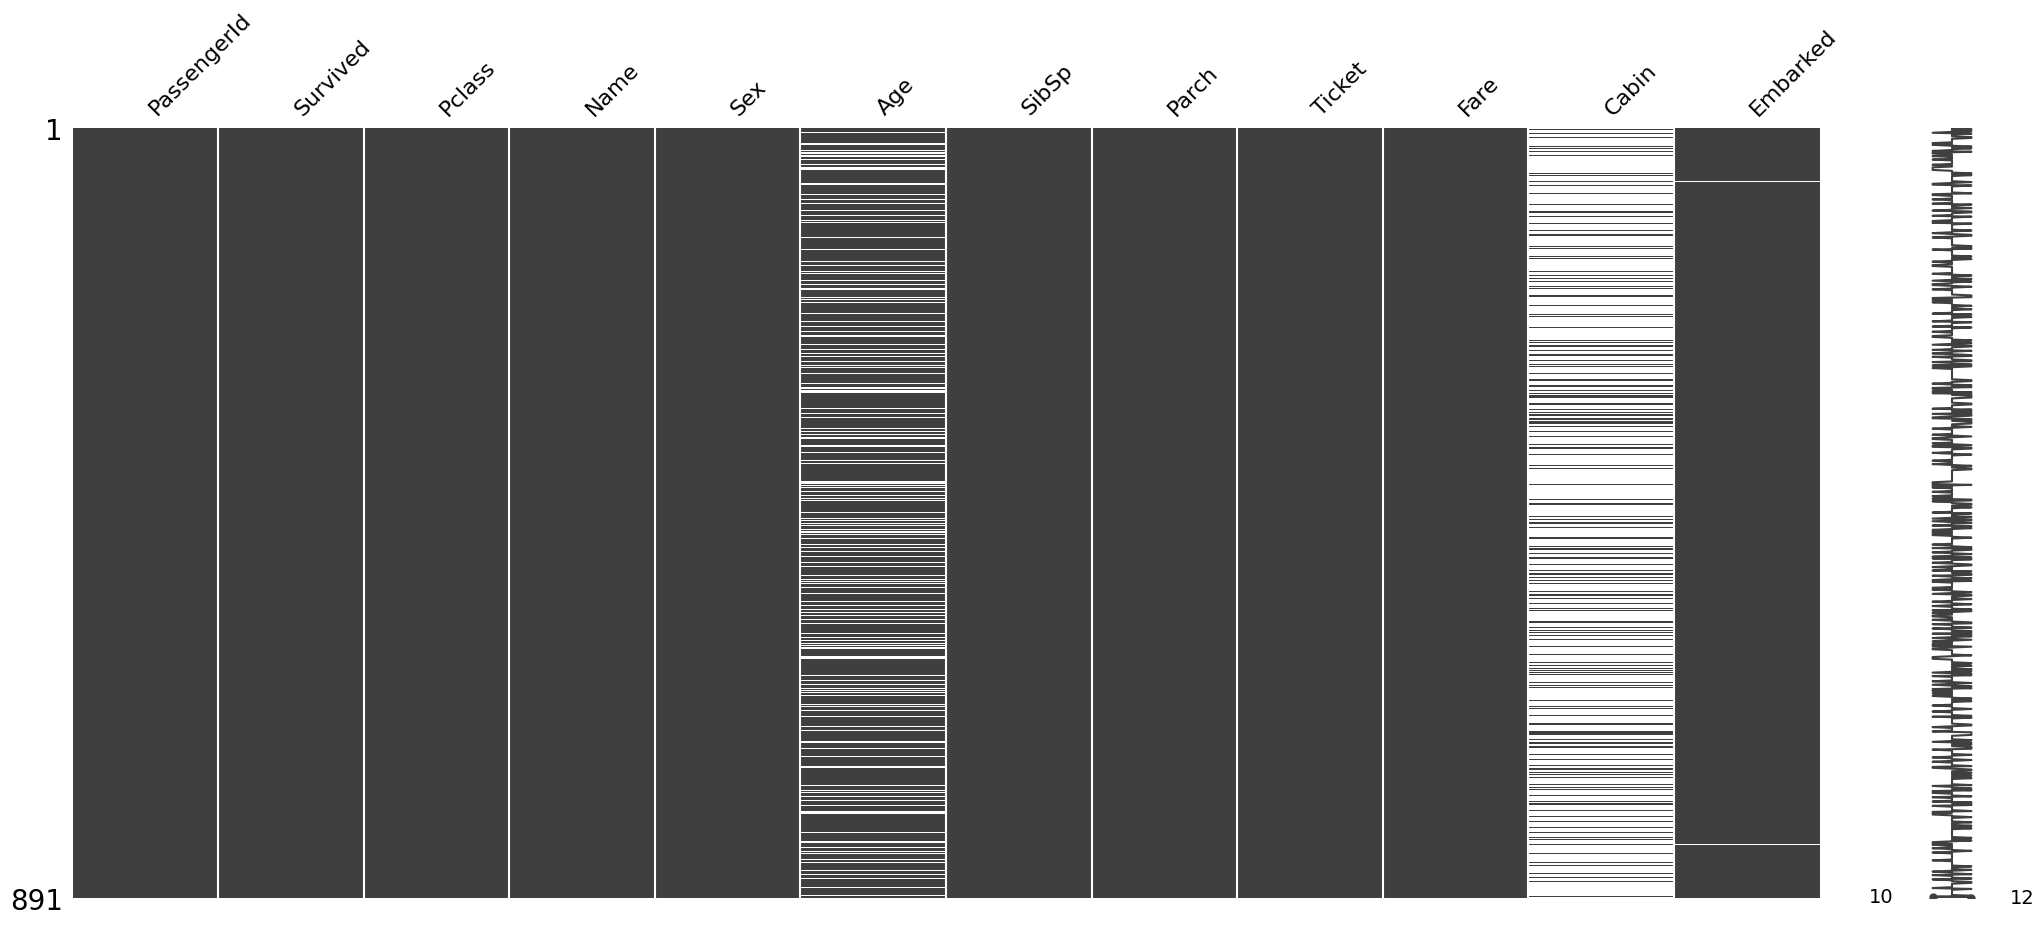

In [41]:
msno.matrix(train_data)

Let's see if we have any duplicates:

In [42]:
duplicated = train_data.duplicated()

print("Number of duplicated instances:", duplicated.sum())

train_data[duplicated]

Number of duplicated instances: 0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


Let's take a look at the numerical attributes:

In [43]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* only 38% **Survived**. :(  That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
* The mean **Fare** was £32.20, which does not seem so expensive (but it was probably a lot of money back then).
* The mean **Age** was less than 30 years old.

Let's check that the target is indeed 0 or 1:

In [44]:
train_data["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

Now let's take a quick look at all the categorical attributes:

In [45]:
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [46]:
train_data["Sex"].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [47]:
train_data["Cabin"].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.


# Ploting relashionship between variables

Correlation

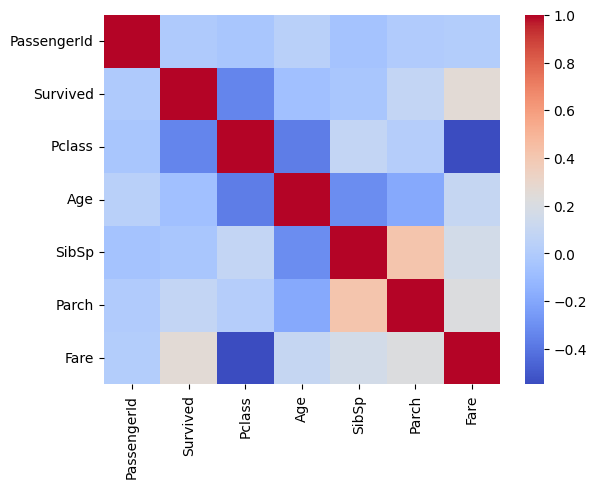

In [48]:
# Check for non-numeric columns
non_numeric_columns = train_data.select_dtypes(exclude=[np.number]).columns

# Drop non-numeric columns
numeric_data = train_data.drop(columns=non_numeric_columns)

# Calculate correlation matrix
corr = numeric_data.corr()
sns.heatmap(corr, cmap="coolwarm");

Survived

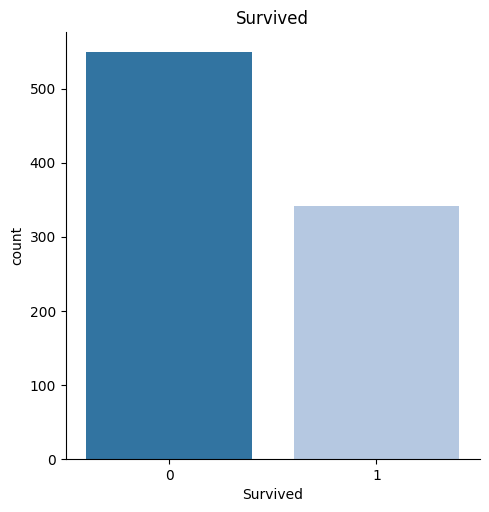

In [49]:
sns.catplot(x='Survived', data=train_data, kind='count', palette='tab20').set(title='Survived')
plt.show()

Pclass and Survived

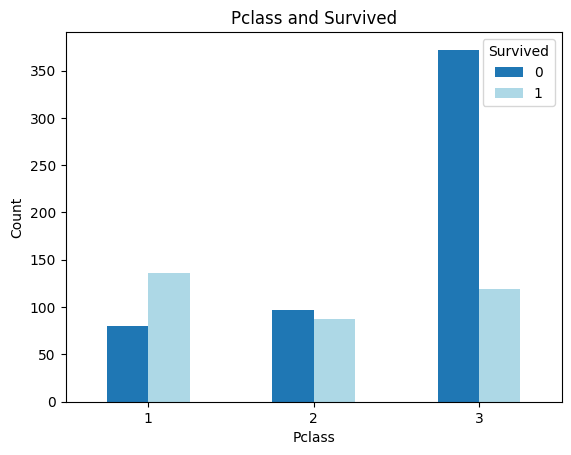

In [50]:
# Create a cross-tabulation table
ct = pd.crosstab(train_data['Pclass'], train_data['Survived'])

# Plot the table
ax = ct.plot(kind='bar', color=['#1f77b4', '#ADD8E6'])
plt.title('Pclass and Survived')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Sex and Survived

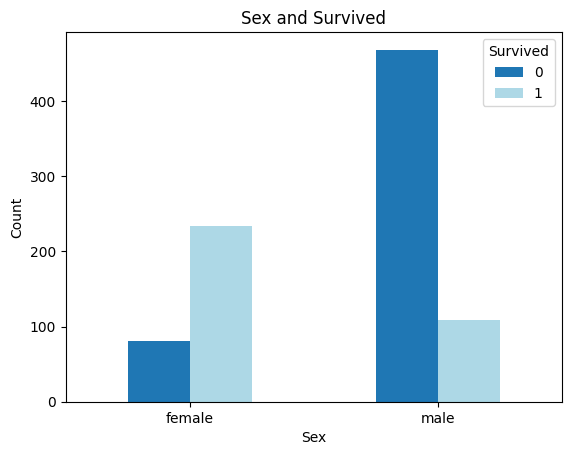

In [51]:
# Create a cross-tabulation table
ct = pd.crosstab(train_data['Sex'], train_data['Survived'])

# Plot the table
ax = ct.plot(kind='bar', color=['#1f77b4', '#ADD8E6'])
plt.title('Sex and Survived')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Embarked and Pclass

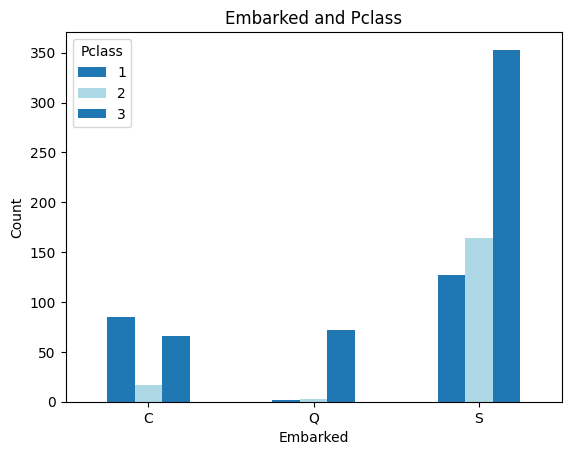

In [52]:
# Create a cross-tabulation table
ct = pd.crosstab(train_data['Embarked'], train_data['Pclass'])

# Plot the table
ax = ct.plot(kind='bar', color=['#1f77b4', '#ADD8E6'])
plt.title('Embarked and Pclass')
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Age Distribution

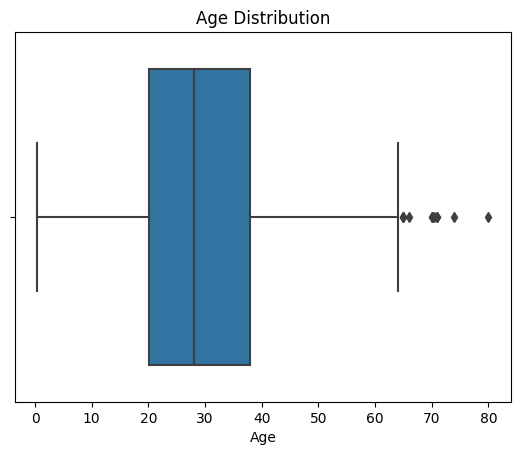

In [53]:
sns.boxplot(x='Age', data=train_data).set(title='Age Distribution')
plt.show()

Survived and Age

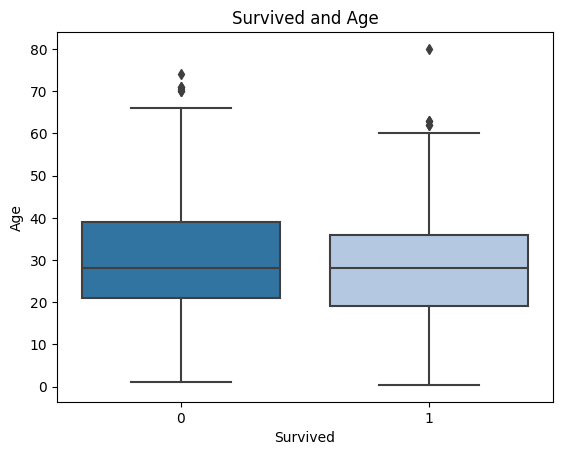

In [54]:
sns.boxplot(x='Survived', y='Age', data=train_data, palette='tab20').set(title='Survived and Age')
plt.show()

# Data Cleaning

Removing categorial values:

In [55]:
train_data = train_data.drop("Name", axis=1)
train_data = train_data.drop("Ticket", axis=1)

In [56]:
# Pipeline for the numerical attributes:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median'))
])


# Pipeline for the categorical attributes:
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

In [57]:
# Interpret results:

# Impute missing values in the Age column
print("Missing values in Age column before Imputation: ", train_data['Age'].isnull().sum())
train_data['Age'] = num_pipeline.fit_transform(train_data[['Age']])
print("Missing values in Age column after Imputation: ", train_data['Age'].isnull().sum())

# Impute missing values in the Embarked column
print("\nMissing values in Embarked column before Imputation: ", train_data['Embarked'].isnull().sum())
train_data['Embarked'] = cat_pipeline.fit_transform(train_data[['Embarked']])
print("Missing values in Embarked column after Imputation: ", train_data['Embarked'].isnull().sum())

# Encode the categorical values
train_data[['Sex', "Cabin"]] = cat_pipeline.fit_transform(train_data[['Sex', "Cabin"]])
print("\nCategorical values after encoding: ")
train_data[['Embarked', 'Sex', "Cabin"]]

Missing values in Age column before Imputation:  177
Missing values in Age column after Imputation:  0

Missing values in Embarked column before Imputation:  2
Missing values in Embarked column after Imputation:  0

Categorical values after encoding: 


,Embarked,Sex,Cabin
0,2.0,1.0,47.0
1,0.0,0.0,81.0
2,2.0,0.0,47.0
3,2.0,0.0,55.0
4,2.0,1.0,47.0
...,...,...,...
886,2.0,1.0,47.0
887,2.0,0.0,30.0
888,2.0,0.0,47.0
889,0.0,1.0,60.0


We are now ready to train a classifier. 

# Machine Learning

Pre-processing Steps for Machine Learning

In [58]:
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

Splitting the data

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Feature Scaling

In [60]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Logistic Regression Classifier

In [61]:
# Create Logistic Regression classifier
LG_classifier = LogisticRegression(random_state=42)
LG_classifier.fit(X_train, y_train)
LG_y_pred = LG_classifier.predict(X_test)

# Compute the confusion matrix
LG_cm = confusion_matrix(y_test, LG_y_pred)
print("Confusion Matrix:")
print(LG_cm)

# Compute the accuracy score
LG_accuracy = accuracy_score(y_test, LG_y_pred)
print("Accuracy: {:.2f}".format(LG_accuracy))

# Compute the classification report
LG_report = classification_report(y_test, LG_y_pred)
print("Classification Report:")
print(LG_report)

Confusion Matrix:
[[90 15]
 [19 55]]
Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



# Random Forest Classifier

In [62]:
# Create Random Forest classifier
RF_classifier = RandomForestClassifier(random_state=42)
RF_classifier.fit(X_train, y_train)
RF_y_pred = RF_classifier.predict(X_test)

# Compute the confusion matrix
RF_cm = confusion_matrix(y_test, RF_y_pred)
print("Confusion Matrix:")
print(RF_cm)

# Compute the accuracy score
RF_accuracy = accuracy_score(y_test, RF_y_pred)
print("Accuracy: {:.2f}".format(RF_accuracy))

# Compute the classification report
RF_report = classification_report(y_test, RF_y_pred)
print("Classification Report:")
print(RF_report)

Confusion Matrix:
[[93 12]
 [19 55]]
Accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       105
           1       0.82      0.74      0.78        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



# Decision Tree Classifier

In [63]:
# Create Decision Tree classifier
DT_classifier = DecisionTreeClassifier(random_state=42)
DT_classifier.fit(X_train, y_train)
DT_y_pred = DT_classifier.predict(X_test)

# Compute the confusion matrix
DT_cm = confusion_matrix(y_test, DT_y_pred)
print("Confusion Matrix:")
print(DT_cm)

# Compute the accuracy score
DT_accuracy = accuracy_score(y_test, DT_y_pred)
print("Accuracy: {:.2f}".format(DT_accuracy))

# Compute the classification report
DT_report = classification_report(y_test, DT_y_pred)
print("Classification Report:")
print(DT_report)

Confusion Matrix:
[[84 21]
 [21 53]]
Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       105
           1       0.72      0.72      0.72        74

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179



# Classifier accuracy comparison

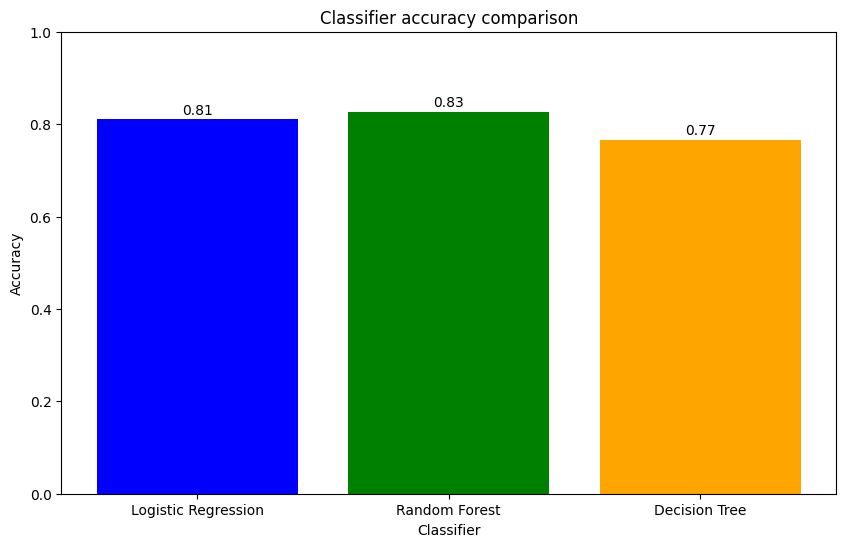

In [64]:
# Classifier names
classifiers = ['Logistic Regression', 'Random Forest', 'Decision Tree']

# Corresponding accuracies
accuracies = [LG_accuracy, RF_accuracy, DT_accuracy]

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(classifiers, accuracies, color=['blue', 'green', 'orange'])
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Classifier accuracy comparison')
plt.ylim(0, 1)

# Annotating each bar with its corresponding accuracy value
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", color='black', ha='center', va='center')

plt.show()

# Cross Validation for the best model

In [65]:
# Specify the cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(RF_classifier, X, y, cv=cv, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Calculate and print the mean and standard deviation of the scores
mean_score = scores.mean()
std_score = scores.std()
print(f"Mean accuracy: {mean_score:.2f}")
print(f"Standard deviation: {std_score:.2f}")

Cross-validation scores: [0.9        0.80898876 0.82022472 0.86516854 0.75280899 0.87640449
 0.85393258 0.80898876 0.85393258 0.82022472]
Mean accuracy: 0.84
Standard deviation: 0.04


# ROC curve for the best model 

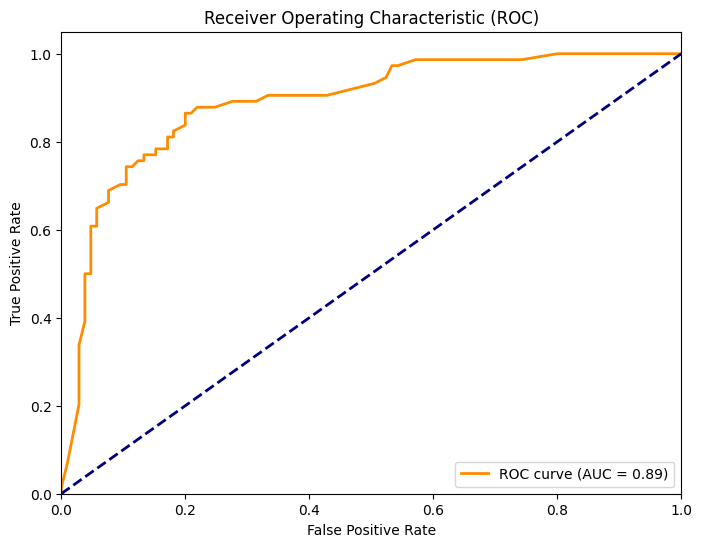

In [66]:
# Calculate ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_test, RF_classifier.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Feature Importance for the best model

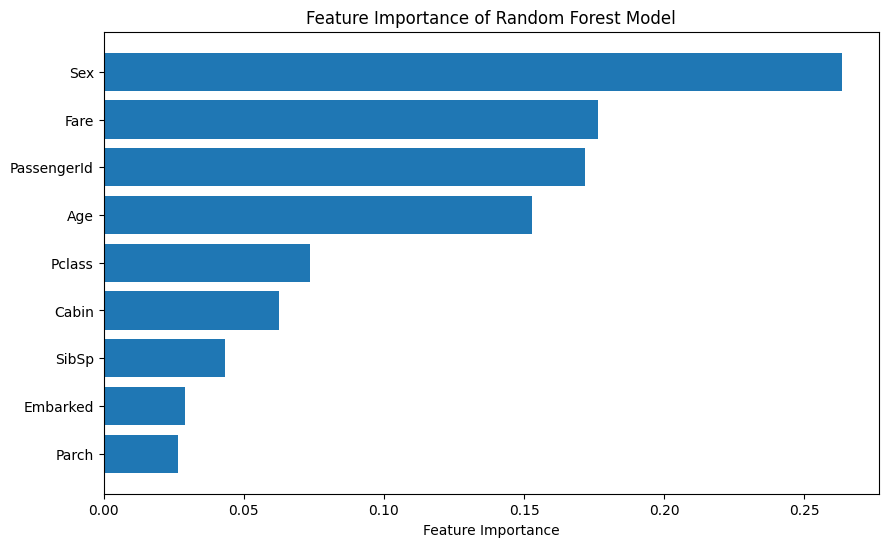

In [67]:
# Get feature importances
feature_importance = RF_classifier.feature_importances_
feature_names = X.columns

# Sort features by importance
sorted_idx = feature_importance.argsort()

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance of Random Forest Model')
plt.show()

# Grid Search for the best model

In [68]:
# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=RF_classifier, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'n_estimators': 150}
Best Accuracy: 0.8370432384516893
